<a href="https://colab.research.google.com/github/BigOyayubi/PyTorchTutorial/blob/master/PyTorch1_1_Image_02_FinetuningTorchVisionModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

TorchVisionモデル群をどのようにしてFineTuning/featureExtract(特徴抽出)していくかを学びます。

FineTuningでは事前訓練済みモデルの全パラメータを更新します。
FeatureExtractionでは事前訓練済みモデルの最終層重みのみ更新します。

流れはどちらも同じように以下のようになります。


*   事前訓練済みモデル初期化
*   最終層（ら）の出力数を新しいデータセットの分類数に合わせる
*   パラメータの最適化関数を用意
*   学習



In [29]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.1.0
Torchvision Version:  0.3.0


In [30]:
#学習用データのDL
!wget --no-clobber https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -f hymenoptera_data.zip -d data
!ls -la data/hymenoptera_data/train/ants/

File ‘hymenoptera_data.zip’ already there; not retrieving.

Archive:  hymenoptera_data.zip
total 13072
drwxr-xr-x 2 root root   4096 Sep 27 08:27  .
drwxr-xr-x 4 root root   4096 Mar 13  2017  ..
-rw-r--r-- 1 root root  46706 Mar 13  2017  0013035.jpg
-rw-r--r-- 1 root root 174618 Mar 13  2017  1030023514_aad5c608f9.jpg
-rw-r--r-- 1 root root 126867 Mar 13  2017  1095476100_3906d8afde.jpg
-rw-r--r-- 1 root root  74013 Mar 13  2017  1099452230_d1949d3250.jpg
-rw-r--r-- 1 root root 143363 Mar 13  2017  116570827_e9c126745d.jpg
-rw-r--r-- 1 root root  68516 Mar 13  2017  1225872729_6f0856588f.jpg
-rw-r--r-- 1 root root  92614 Mar 13  2017  1262877379_64fcada201.jpg
-rw-r--r-- 1 root root  58536 Mar 13  2017  1269756697_0bce92cdab.jpg
-rw-r--r-- 1 root root 101735 Mar 13  2017  1286984635_5119e80de1.jpg
-rw-r--r-- 1 root root 113608 Mar 13  2017  132478121_2a430adea2.jpg
-rw-r--r-- 1 root root 142525 Mar 13  2017  1360291657_dc248c5eea.jpg
-rw-r--r-- 1 root root  90708 Mar 13  2017  136891

In [0]:
#各種パラメータを初期化します。
#model_nameで指定するモデルは以下の著名なものの中から選びます
# [resnet, alexnet, vgg, squeezenet, densenet, inception]

# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "./data/hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "squeezenet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [0]:
#学習と検証を行う関数を用意しておく
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [0]:
#feature extracingでは初期化された層のみ計算したいので、他層は勾配追跡をOFFにする
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [34]:
#モデルの初期化ヘルパ
#事前訓練済みモデル種別に応じて適宜設定する
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract) #feature_extract:FalseのときFineTuning(全パラメータ更新)動作
        #事前訓練済みモデル最終層を新規学習用に差し替え。入力チャンネル数は事前訓練済みモデルと揃える
        #差し替える層の名前はモデルで異なる
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): Fire(
      (squeeze): Conv2d(128, 32, kerne

In [35]:
#データロード
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [36]:
#最適化関数の用意
#feature_extract:Trueのとき、対象は最終層パラメータのみのはず

# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.squeeze.weight
	 features.3.squeeze.bias
	 features.3.expand1x1.weight
	 features.3.expand1x1.bias
	 features.3.expand3x3.weight
	 features.3.expand3x3.bias
	 features.4.squeeze.weight
	 features.4.squeeze.bias
	 features.4.expand1x1.weight
	 features.4.expand1x1.bias
	 features.4.expand3x3.weight
	 features.4.expand3x3.bias
	 features.5.squeeze.weight
	 features.5.squeeze.bias
	 features.5.expand1x1.weight
	 features.5.expand1x1.bias
	 features.5.expand3x3.weight
	 features.5.expand3x3.bias
	 features.7.squeeze.weight
	 features.7.squeeze.bias
	 features.7.expand1x1.weight
	 features.7.expand1x1.bias
	 features.7.expand3x3.weight
	 features.7.expand3x3.bias
	 features.8.squeeze.weight
	 features.8.squeeze.bias
	 features.8.expand1x1.weight
	 features.8.expand1x1.bias
	 features.8.expand3x3.weight
	 features.8.expand3x3.bias
	 features.9.squeeze.weight
	 features.9.squeeze.bias
	 features.9.expand1x1.weight
	 features.

In [0]:
#損失関数の用意
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

In [38]:
#学習と検証の実行
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------
train Loss: 0.5733 Acc: 0.7131
val Loss: 0.5373 Acc: 0.7516

Epoch 1/14
----------
train Loss: 0.4761 Acc: 0.7787
val Loss: 0.3271 Acc: 0.9020

Epoch 2/14
----------
train Loss: 0.3627 Acc: 0.8279
val Loss: 0.3302 Acc: 0.8627

Epoch 3/14
----------
train Loss: 0.2911 Acc: 0.8730
val Loss: 0.4465 Acc: 0.7647

Epoch 4/14
----------
train Loss: 0.3381 Acc: 0.8934
val Loss: 0.3114 Acc: 0.9020

Epoch 5/14
----------
train Loss: 0.2837 Acc: 0.8648
val Loss: 0.4422 Acc: 0.8235

Epoch 6/14
----------
train Loss: 0.2666 Acc: 0.8730
val Loss: 0.2984 Acc: 0.9085

Epoch 7/14
----------
train Loss: 0.3249 Acc: 0.8730
val Loss: 0.3602 Acc: 0.8758

Epoch 8/14
----------
train Loss: 0.2473 Acc: 0.8730
val Loss: 0.5499 Acc: 0.7778

Epoch 9/14
----------
train Loss: 0.2483 Acc: 0.8975
val Loss: 0.4915 Acc: 0.8235

Epoch 10/14
----------
train Loss: 0.2190 Acc: 0.9262
val Loss: 0.5558 Acc: 0.7712

Epoch 11/14
----------
train Loss: 0.1682 Acc: 0.9262
val Loss: 0.4448 Acc: 0.8758

Ep

Epoch 0/14
----------
train Loss: 0.6990 Acc: 0.4795
val Loss: 0.6931 Acc: 0.4575

Epoch 1/14
----------
train Loss: 0.6917 Acc: 0.5123
val Loss: 0.6931 Acc: 0.4575

Epoch 2/14
----------
train Loss: 0.6917 Acc: 0.4959
val Loss: 0.6931 Acc: 0.4902

Epoch 3/14
----------
train Loss: 0.6840 Acc: 0.4959
val Loss: 0.6924 Acc: 0.5294

Epoch 4/14
----------
train Loss: 0.6862 Acc: 0.4959
val Loss: 0.6931 Acc: 0.4575

Epoch 5/14
----------
train Loss: 0.6931 Acc: 0.5041
val Loss: 0.6931 Acc: 0.4575

Epoch 6/14
----------
train Loss: 0.6932 Acc: 0.5082
val Loss: 0.6931 Acc: 0.4575

Epoch 7/14
----------
train Loss: 0.6932 Acc: 0.5041
val Loss: 0.6931 Acc: 0.4575

Epoch 8/14
----------
train Loss: 0.6932 Acc: 0.5041
val Loss: 0.6931 Acc: 0.4575

Epoch 9/14
----------
train Loss: 0.6932 Acc: 0.5041
val Loss: 0.6931 Acc: 0.4575

Epoch 10/14
----------
train Loss: 0.6932 Acc: 0.5082
val Loss: 0.6931 Acc: 0.4575

Epoch 11/14
----------
train Loss: 0.6931 Acc: 0.5041
val Loss: 0.6931 Acc: 0.4575

Ep

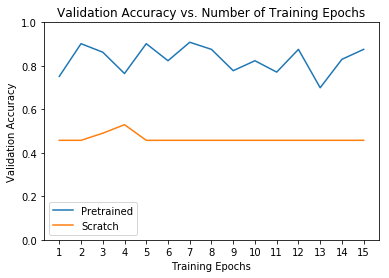

In [39]:
#事前学習データをセットしていないモデルで少数データで学習させて、比較
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()